# Plot spindle current versus temperature

We want to visualize the relationship between the current and the temperature of the spindle. In order to do that, we want to take averages by given time slots. 

In [28]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.optimize import minimize

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

current_folder = os.getcwd()
print(current_folder)

from parse.loadCsvSignal import loadCsvSignal
from temperatureCorrection.showTempCorrectionPlots import showTempCorrectionPlots
from utils.detectConstantSegments import detectConstantSegments
from utils.computeSlotsAverage import computeSlotsAverage
from temperatureCorrection.getTemperatureCorrectionData import getTemperatureCorrectionData

/Users/opatiny/git/opatiny/predictiveMaintenance/src/notebooks


## Load some data

   

In [ ]:
folderPath = "../../data/Mecatis/05_02_25/"

temperature = "lrSigSpindleTemp.csv"
currentSlots = "stSigAxCurrentS.csv"

tempPath = current_folder + "/" + folderPath + temperature
currentPath = current_folder + "/" + folderPath + currentSlots


temperatureData = loadCsvSignal(tempPath, normalize=True, debug=True)
currentData = loadCsvSignal(currentPath, normalize=True, debug=True)


getFormattedSignalData - Number of points to sort:  4272
removeDuplicates - Number duplicates: 1038
getFormattedSignalData - Number of points to sort:  2065466
removeDuplicates - Number duplicates: 0


### Plot the data

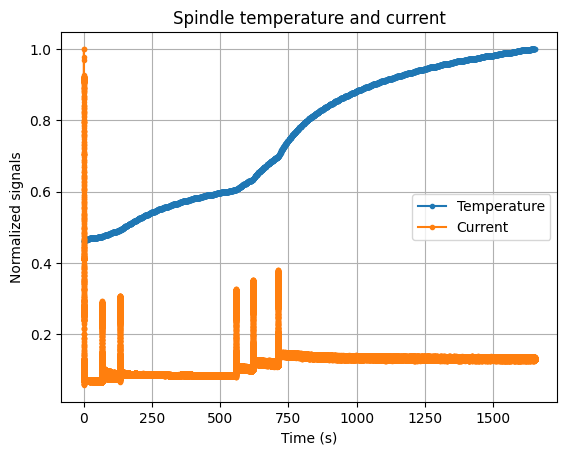

In [5]:
plt.plot(
    temperatureData.loc[:, "timeSeconds"], temperatureData.loc[:, "value"], "o-", markersize=3)
plt.plot(
    currentData.loc[:, "timeSeconds"], currentData.loc[:, "value"], "o-", markersize=3)
plt.xlabel("Time (s)")
# plt.ylabel("Temperature (°C) / Current (A)")
plt.ylabel("Normalized signals")
plt.legend(["Temperature", "Current"])

plt.title("Spindle temperature and current")
plt.grid()

plt.show()

### Plot the data averaged by slots

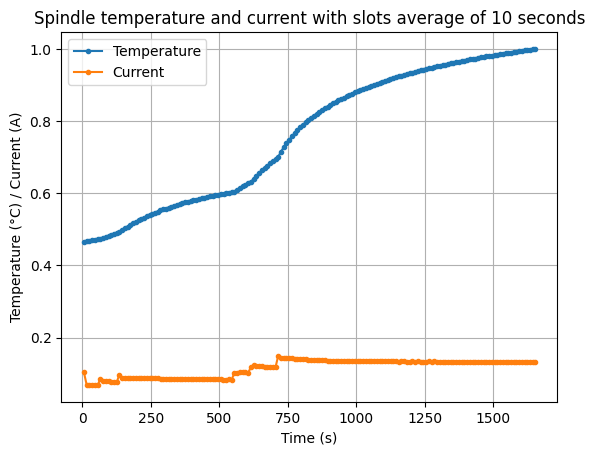

In [7]:
# apply the function to the temperature and current data
dt = 10 # seconds

temperatureSlots = computeSlotsAverage(temperatureData, dt)
currentSlots = computeSlotsAverage(currentData, dt)

# plot data versus time
plt.plot(
    temperatureSlots.loc[:, "timeSeconds"], temperatureSlots.loc[:, "value"], "o-", markersize=3)

plt.plot(
    currentSlots.loc[:, "timeSeconds"], currentSlots.loc[:, "value"], "o-", markersize=3)
plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C) / Current (A)")
plt.legend(["Temperature", "Current"])
plt.title("Spindle temperature and current with slots average of " + str(dt) + " seconds")
plt.grid()
plt.show()

### Plot the current versus temperature

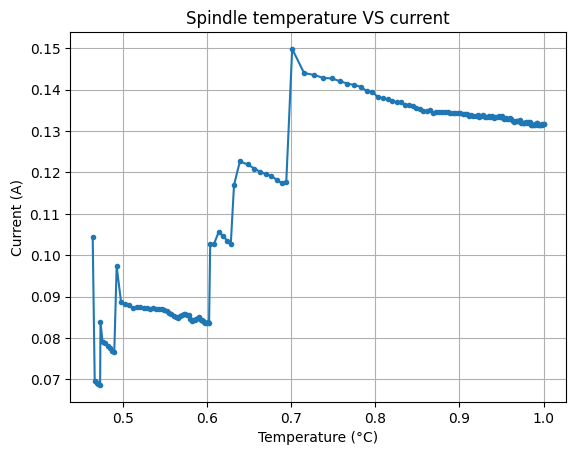

In [8]:
plt.plot(
    temperatureSlots.loc[:, "value"], currentSlots.loc[:, "value"], "-o", markersize=3)
plt.xlabel("Temperature (°C)")
plt.ylabel("Current (A)")
plt.title("Spindle temperature VS current")
plt.grid()
plt.show()

## Test `etTemperatureCorrectionData` on various samples

We want to plot the current VS temperature plot for multiple samples.

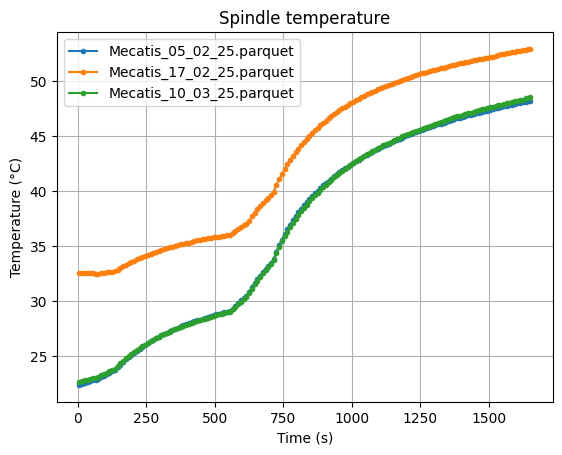

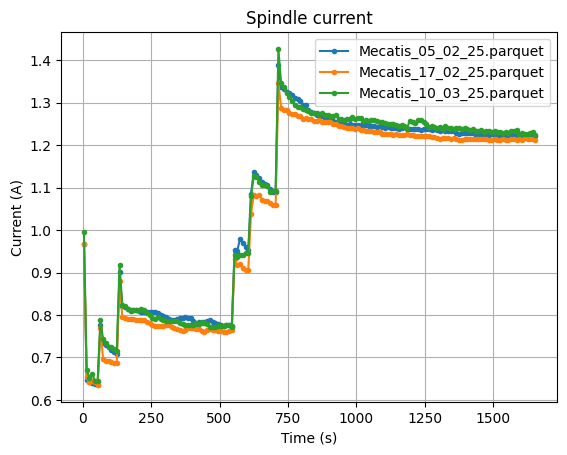

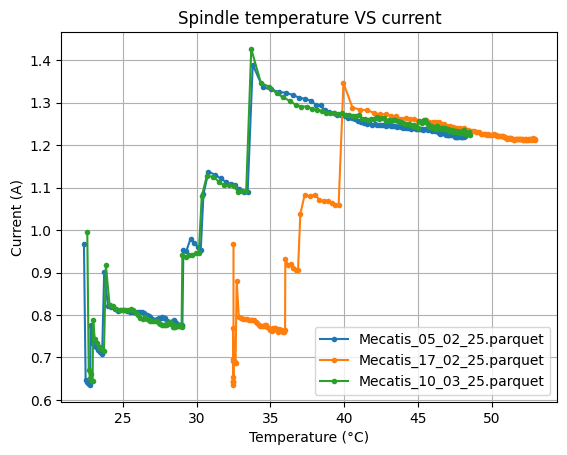

In [ ]:
dataPath: Path = "../../data/normalized-2025_04_08/"

samples: list[Path] = ["Mecatis_05_02_25.parquet", "Mecatis_17_02_25.parquet", "Mecatis_10_03_25.parquet"] 

rawData = []
for sample in samples:
    path = os.path.join(dataPath, sample)
    currentData = pd.read_parquet(path)
    rawData.append(getTemperatureCorrectionData(currentData))

showTempCorrectionPlots(rawData, samples)

## Finding optimal temperature offset 

We want to minimize the distance between a temperature signal and a reference using just an offset.

In [3]:


def fun(x: float, data: pd.Series, reference: pd.Series) -> float:
    error = ((data - x - reference)**2).sum()/len(data) # mean square error (MSE)
    return error

def findTemperatureOffset(temperature: pd.Series, reference: pd.Series) -> float:
    """
    Find the temperature offset that minimizes the error between the temperature and reference.

    Parameters
    ----------
    temperature (pd.Series): The temperature data.
    reference (pd.Series): The reference data.

    Returns
    -------
    float: The temperature offset.
    """
    x0 = 0.0 # start with an offset of 0°C
    result = minimize(fun, x0, args=(temperature, reference))
    return result.x[0], np.sqrt(result.fun) # return the offset and the rmse

### Test the function on some data


In [ ]:
offset1, error1 = findTemperatureOffset(rawData[1]["temperature"], rawData[0]["temperature"])

print("sample 1: ", samples[1])
print("Offset: ", offset1.round(2), "°C")
print("RMSE: ", error1.round(2), "°C")

offset2, error2 = findTemperatureOffset(rawData[2]["temperature"], rawData[0]["temperature"])
print("sample 2: ", samples[2])
print("Offset: ", offset2.round(2), "°C")
print("RMSE: ", error2.round(2), "°C")


sample 1:  Mecatis_17_02_25.parquet
Offset:  6.35 °C
RMSE:  1.47 °C
sample 2:  Mecatis_10_03_25.parquet
Offset:  0.04 °C
RMSE:  0.14 °C


### Plot the corrected data

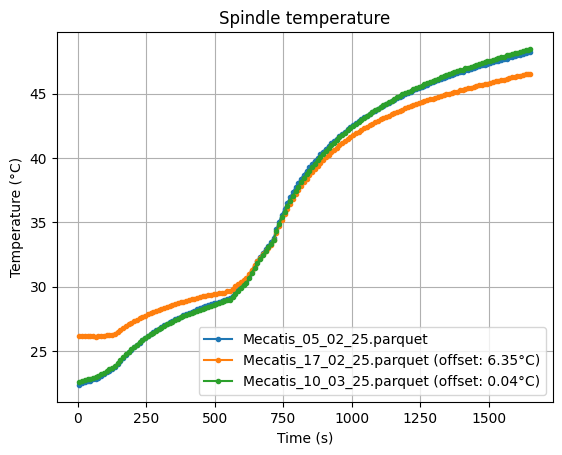

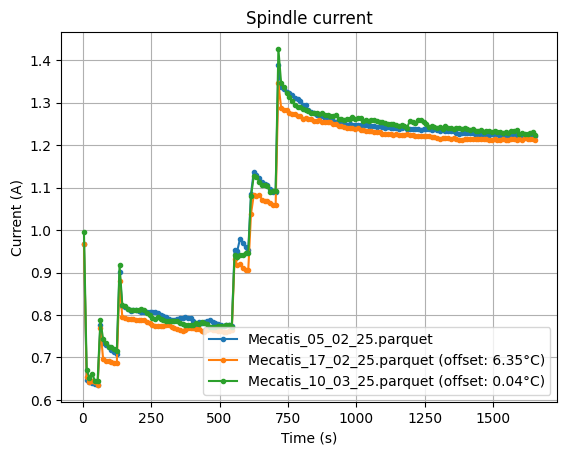

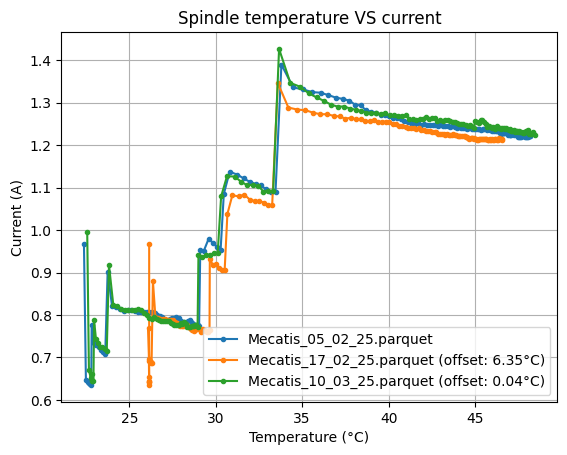

In [ ]:
rawData[1]["temperature"] = rawData[1]["temperature"] - offset1
samples[1] = samples[1] + " (offset: " + str(offset1.round(2)) + "°C)"

rawData[2]["temperature"] = rawData[2]["temperature"] - offset2
samples[2] = samples[2] + " (offset: " + str(offset2.round(2)) + "°C)"

showTempCorrectionPlots(rawData, samples)

## Check if segments are the same in all samples

In [6]:

dataPath: Path = "../../data/normalized-2025_04_08/"

def getSampleSegmentIndices(samplePath: Path) -> list:
    """
    Get the sample segment indices.

    Parameters
    ----------
    samplePath (str): The path to the sample.

    Returns
    -------
    list: Indices of the sample segments.
    """
    data = pd.read_parquet(samplePath)
    time = data["timeSeconds"]
    command = data["stSigSpindleVelocity"]
    return detectConstantSegments(time, command)

indices1 = getSampleSegmentIndices(os.path.join(dataPath, "Mecatis_05_02_25.parquet"))
print("Indices 1: ", indices1)
indices2 = getSampleSegmentIndices(os.path.join(dataPath, "Mecatis_17_02_25.parquet"))
print("Indices 2: ", indices2)
indices3 = getSampleSegmentIndices(os.path.join(dataPath, "Mecatis_10_03_25.parquet"))
print("Indices 3: ", indices3)


Indices 1:  [(893, 84083), (84959, 165527), (166403, 694810), (695686, 772705), (773581, 889295), (890171, 2065465)]
Indices 2:  [(893, 84072), (84948, 165512), (166388, 694795), (695670, 772677), (773552, 889265), (890141, 2065435)]
Indices 3:  [(892, 84083), (84958, 165521), (166396, 694796), (695672, 772690), (773566, 889276), (890151, 2065449)]


Remarks:
- different samples have different segment indices
- samples contains different numcer of points

## Split spindle current into segments
We want to split all the spindle current into segments and process each of the segments independently. First we need to find the start and end indices of the segments.

First, load a sample and put useful signals into some variables.

In [19]:
dataPath: Path = "../../data/normalized-2025_04_08/"
samplePath = os.path.join(dataPath, "Mecatis_05_02_25.parquet")

rawData = pd.read_parquet(samplePath)
time = rawData["timeSeconds"]
command = rawData["stSigSpindleVelocity"]
segmentIndices = detectConstantSegments(time, command)
data = getTemperatureCorrectionData(rawData, timeSlot=None)


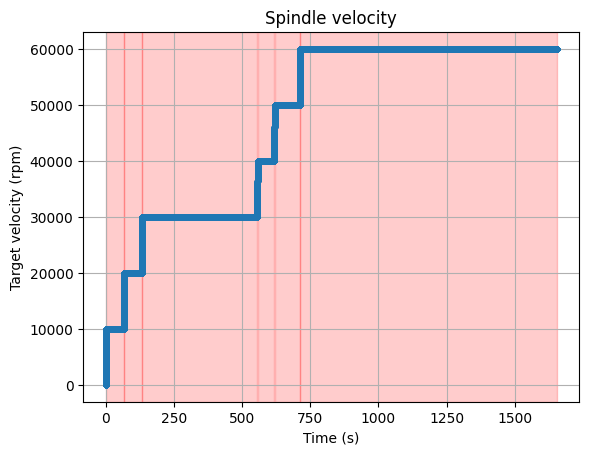

In [20]:
# plot the data
plt.figure()
plt.plot(time, command, "o-", markersize=3)
plt.xlabel("Time (s)")
plt.ylabel("Target velocity (rpm)")
plt.title("Spindle velocity")
plt.grid()
for segment in segmentIndices:
    plt.axvspan(time[segment[0]], time[segment[1]], color="red", alpha=0.2)
plt.show()

## Cut a signal into the segments and plot all the segments versus time

### Define functions

In [8]:
def splitSignal(data: pd.DataFrame, indices: list) -> list:
    """
    Split the data into segments.

    Parameters
    ----------
    signal (pd.DataFrame): The data, which can have any number of columns.
    indices (list): The indices of the segments.

    Returns
    -------
    list: The segments of the signal.
    """
    segments = []
    for segment in indices:
        segments.append(data.iloc[segment[0]:segment[1]])
    return segments

In [30]:
def plotSegments(segments: list, signalName: str = "current", title = "Spindle current", xlabel: str = "Time (s)", ylabel: str = "Current (A)" ) -> None:
    """
    Plot the segments of the signal.

    Parameters
    ----------
    segments (list[pd.DataFrame]): The segments of the signal. Each signal must only have 2 columns.
    title (str): The title of the plot.
    xlabel (str): The label of the x-axis.
    ylabel (str): The label of the y-axis.

    Returns
    -------
    None
    """

    nbSegments = len(segments)
    if nbSegments != 6:
        print("Warning: the number of segments is not 6. The plot may not be correct.")

    nbColumns = 2
    nbRows = 3

    plt.figure()
    fig, axs = plt.subplots(nbRows, nbColumns, figsize=(12, 8))
    fig.subplots_adjust(hspace=0.5)
    fig.suptitle(title)

    for i in range(len(segmentIndices)):
        x = segments[i].iloc[:, 0]
        y = segments[i].loc[:, signalName]

        colIndex = i % nbColumns
        rowIndex = i // nbColumns

        axs[rowIndex, colIndex].plot(x, y, "o-", markersize=3)
        axs[rowIndex, colIndex].set_xlabel(xlabel)
        axs[rowIndex, colIndex].set_ylabel(ylabel)

        nbPoints = len(x)

        axs[rowIndex, colIndex].set_title("Segment " + str(i+1) + " (" + str(nbPoints) + " points)")
        axs[rowIndex, colIndex].grid()

    plt.show()

### Test plotting raw segments

         timeSeconds  temperature  current
0             0.0000         22.3   3.8001
1             0.0008         22.3   3.8003
2             0.0016         22.3   3.7988
3             0.0024         22.3   3.8005
4             0.0032         22.3   3.7994
...              ...          ...      ...
2065461    1653.1992         48.2   1.1844
2065462    1653.2000         48.2   1.1844
2065463    1653.2008         48.2   1.1883
2065464    1653.2016         48.2   1.1886
2065465    1653.2024         48.2   1.1992

[2065466 rows x 3 columns]
[(893, 84083), (84959, 165527), (166403, 694810), (695686, 772705), (773581, 889295), (890171, 2065465)]
[       timeSeconds  temperature  current
893         0.7144         22.3   0.5706
894         0.7152         22.3   0.5547
895         0.7160         22.3   0.5547
896         0.7168         22.3   0.5651
897         0.7176         22.3   0.5357
...            ...          ...      ...
84078      67.2968         22.8   0.6421
84079      67.2976    

<Figure size 640x480 with 0 Axes>

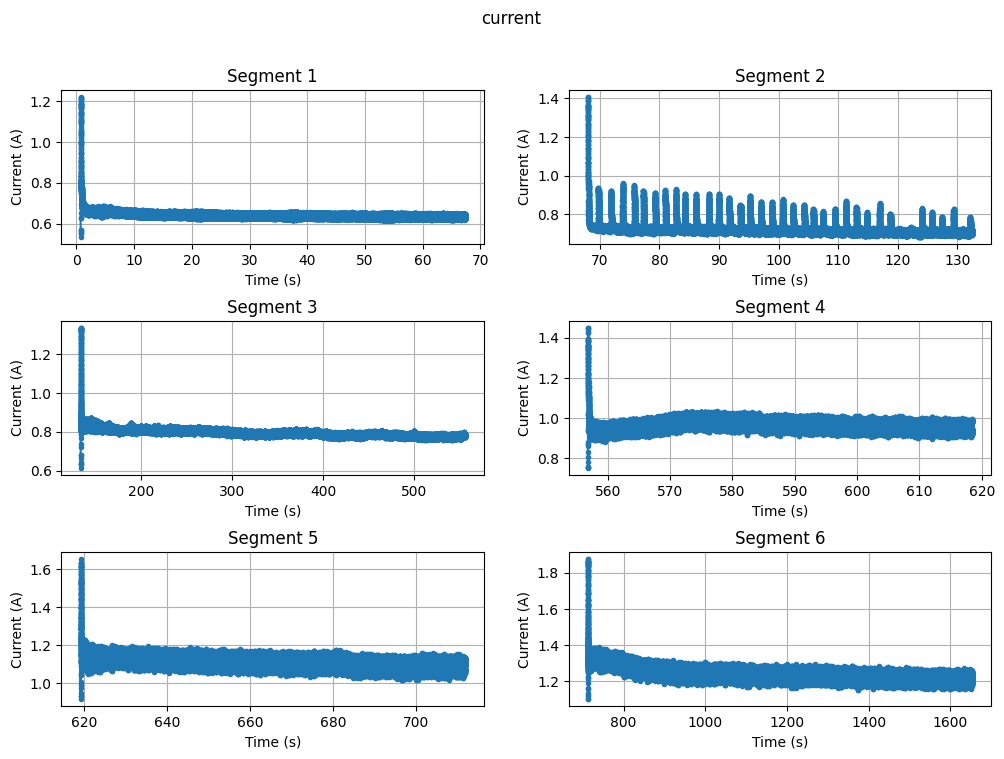

In [ ]:
print(data)
segments = splitSignal(data, segmentIndices)
plotSegments(segments)

### Remove points at the beggining of segments

We want to remove the beginning of each segment in order to be in the stable state.

Frequency:  1250.0 Hz
Number of points to remove:  1250


<Figure size 640x480 with 0 Axes>

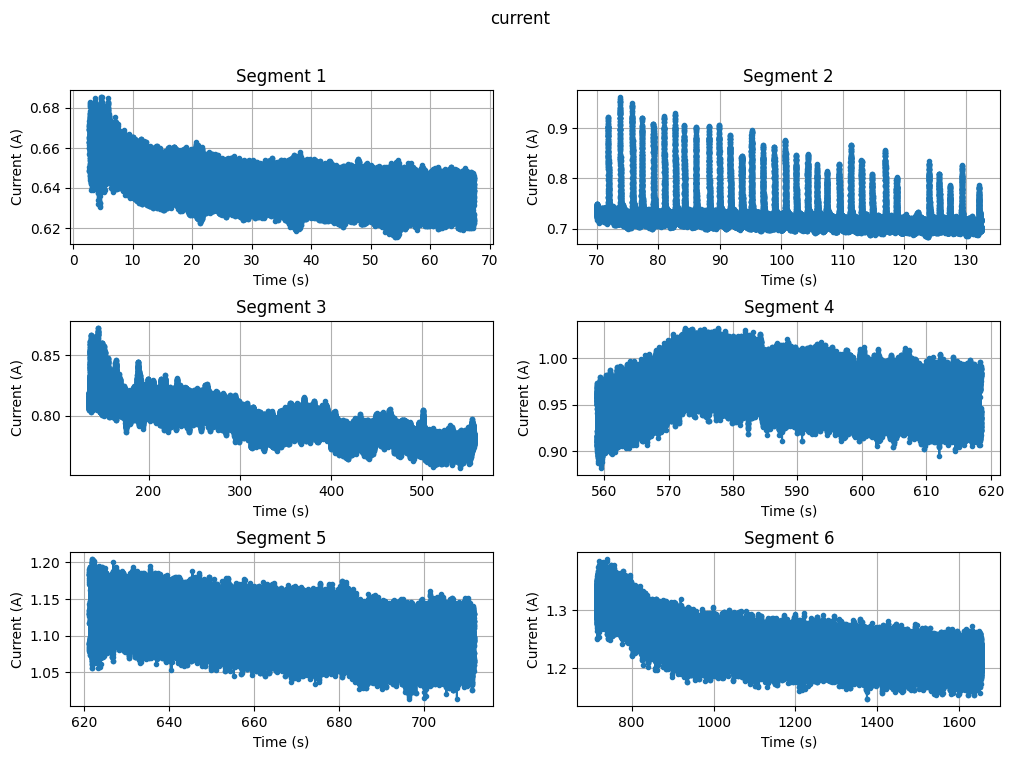

In [26]:
timeToRemove = 1 # seconds
frequency = 1 / (data.iloc[1, 0] - data.iloc[0,0]) # Hz
print("Frequency: ", frequency, "Hz")

nbPointsToRemove = int(timeToRemove * frequency) # number of points to remove
print("Number of points to remove: ", nbPointsToRemove)

for i in range(len(segments)):
    # remove the first nbPointsToRemove points
    segments[i] = segments[i].iloc[nbPointsToRemove:, :]

# plot the segments
plotSegments(segments)


### Compute average by slots to reduce nb of points

<Figure size 640x480 with 0 Axes>

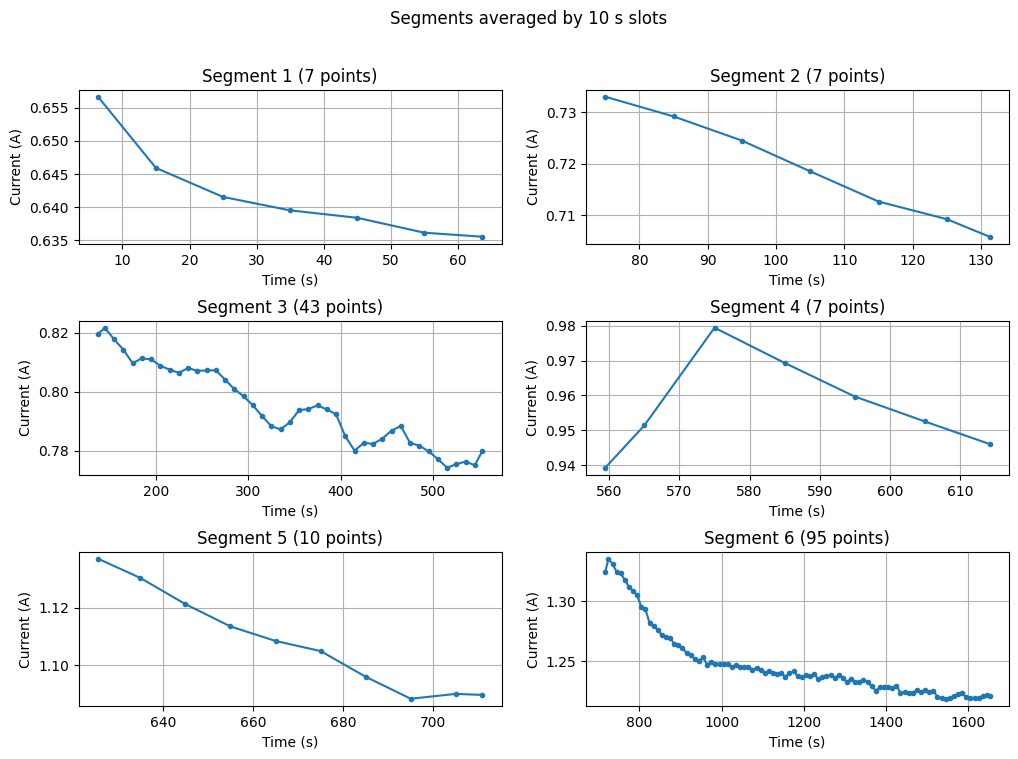

In [ ]:
dt = 10 # seconds

for i in range(len(segments)):
    segments[i] = computeSlotsAverage(segments[i], dt)

# plot the segments
plotSegments(segments, title="Segments averaged by " + str(dt) + " seconds slots")

### Compute linear regression for each segment

In [ ]:

def fun(x: list, data: pd.DataFrame) -> float:
    """
    Function for a linear regression model. The parameters are first the offset and then the slope.
    """
    model = x[0] + x[1] * data.iloc[:, 0] 
    error = ((data.loc[:,1] - model)**2).sum()/len(data) # mean square error (MSE)
    return error

def linearRegression(temperature: pd.Series, reference: pd.Series) -> float:
    """
    Find the temperature offset that minimizes the error between the temperature and reference.

    Parameters
    ----------
    temperature (pd.Series): The temperature data.
    reference (pd.Series): The reference data.

    Returns
    -------
    float: The temperature offset.
    """
    x0 = 0.0 # start with an offset of 0°C
    result = minimize(fun, x0, args=(temperature, reference))
    return result.x[0], np.sqrt(result.fun) # return the offset and the rmse